In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

## KNN

In [2]:
df = pd.read_csv('../../data/final_dataset.csv')


In [3]:
df['Group'] = df['Diagnosis']
df['Group'] = df['Group'].replace('Bipolar I',1)
df['Group'] = df['Group'].replace('Bipolar II',1)
df['Group'] = df['Group'].replace('MDD',2)
df['Group'] = df['Group'].replace('Major Depressive Disorder',2)
df['Group'] = df['Group'].replace('Control',0)

df.columns

Index(['Unnamed: 0', 'Watch Status', 'Phone Brand', 'Diagnosis', 'Gender',
       'Study ID', 'LAMP ID', 'Race', 'Age', 'DOB', 'Date of Consent',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'screen_duration_mean',
       'screen_duration_var', 'internal_sleep_mean', 'internal_sleep_var',
       'PHQ-2_mean', 'PHQ-2_var', 'GAD-2_mean', 'GAD-2_var', 'Group'],
      dtype='object')

In [4]:
# predictor and target vars
X = df[['gps_data_quality_mean', 'gps_data_quality_var',
  'hometime_mean', 'hometime_var', 'entropy_mean', 'screen_duration_mean', 'screen_duration_var',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var']]
y = df['Group']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [6]:
# standardize
scale_train = StandardScaler()
scale_test = StandardScaler()

X_train = scale_train.fit_transform(X_train)
X_test = scale_test.fit_transform(X_test)

In [7]:
# Untuned accuracy
knn_basic = KNeighborsClassifier()
knn_basic.fit(X_train, y_train)
y_pred = knn_basic.predict(X_test)
accuracy_score(y_test, y_pred)

0.23076923076923078

In [8]:
model=KNeighborsClassifier()
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]

# define grid search
grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.457143 using {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.450000 (0.154881) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
0.457143 (0.135652) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.407143 (0.125628) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
0.379762 (0.177911) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
0.395238 (0.213577) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
0.370238 (0.198792) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
0.382143 (0.141030) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
0.408333 (0.107710) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
0.313095 (0.151223) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
0.367857 (0.111002) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
0.321429 (0.131708) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.390476 (0.164294) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
0.383333 (0.143431) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
0.435714 (0.135495) with: {'leaf_size':

In [9]:
params = grid_search.best_params_

In [10]:
knn_tuned = KNeighborsClassifier(leaf_size=params['leaf_size'], 
                                 n_neighbors=params['n_neighbors'], 
                                p=params['p'])
# fit the model with data
knn_tuned.fit(X_train, y_train)

y_pred = knn_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[6, 4, 1],
       [4, 5, 1],
       [4, 7, 7]])

In [11]:
y_pred2=knn_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.46153846153846156

In [12]:
cnf_matrix

array([[6, 4, 1],
       [4, 5, 1],
       [4, 7, 7]])

In [13]:
index_labels=['Control', 'MDD', 'Bipolar']

cnf_df = pd.DataFrame(cnf_matrix, index=index_labels)
cnf_df.columns = ['Control', 'MDD', 'Bipolar']

Text(33.0, 0.5, 'Actual')

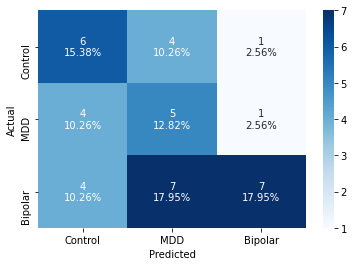

In [14]:
import seaborn as sns

#sns.heatmap(cnf_matrix, annot=True, cmap='Blues')

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(cnf_df, annot=labels, fmt='', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [15]:
pct_dict = {}
for col in cnf_df.columns:
    pct_dict[col] = cnf_df[col]/cnf_df.sum(axis=1)
pct_df = pd.DataFrame(pct_dict)

In [16]:
pct_df

,Control,MDD,Bipolar
Control,0.545455,0.363636,0.090909
MDD,0.400000,0.500000,0.100000
Bipolar,0.222222,0.388889,0.388889
